# Sberbank Russian Housing Market.

*Olga Voitka*

This notebook shows my work on Kaggle competition. The goal of this competition is to predict the sale price of a given property based on the data provided by Sberbank (Russia’s bank).

## 1. Data Exploration.

We have 3 data files: train.csv, test.csv and macro.csv.
Let's upload them and look inside. 

In [2]:
# Count ratio of the missing values and number of the features with missing values
printNA <-function(data){
  numNA <- data.frame(sapply(data, function(x) sum(is.na(x))*100/length(x)))
  numNA$feature <- names(data)
  numNA$num <- c(1:nrow(numNA))
  colnames(numNA) <- c("missing.ratio", "feature", "num")
  numNA <- numNA[, c("num", "feature","missing.ratio")]
  print(numNA[numNA$missing.ratio != 0,], row.names = F)
}
                             
library(tibble)
library(tidyverse)
library(caret)
library(ggplot2)
#library(dplyr)
library(data.table)
library(xgboost)      
                             
# upload test, train files 
train <- fread('train.csv', na.strings = "NA")
test <- fread("test.csv", sep=",", na.strings = "NA")

------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose



Read 30471 rows and 292 (of 292) columns from 0.043 GB file in 00:00:04


In [3]:
dim(train)
str(train)
sample(train)

[1] 30471   292

Classes 'data.table' and 'data.frame':	30471 obs. of  292 variables:
 $ id                                   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ timestamp                            : chr  "2011-08-20" "2011-08-23" "2011-08-27" "2011-09-01" ...
 $ full_sq                              : int  43 34 43 89 77 67 25 44 42 36 ...
 $ life_sq                              : int  27 19 29 50 77 46 14 44 27 21 ...
 $ floor                                : int  4 3 2 9 4 14 10 5 5 9 ...
 $ max_floor                            : int  NA NA NA NA NA NA NA NA NA NA ...
 $ material                             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ build_year                           : int  NA NA NA NA NA NA NA NA NA NA ...
 $ num_room                             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ kitch_sq                             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ state                                : int  NA NA NA NA NA NA NA NA NA NA ...
 $ product_type                    

young_female,basketball_km,cafe_count_3000_price_2500,num_room,cafe_count_500,ecology,green_part_1500,cafe_count_500_price_2500,0_13_male,cafe_sum_3000_max_price_avg,...,build_count_before_1920,university_top_20_raion,sport_count_3000,church_count_1500,full_all,hospital_beds_raion,ID_big_road2,work_all,sport_count_1500,prom_part_5000
10147,3.5165129,3,NA,0,good,14.27,0,9709,1079.37,...,0,0,21,2,86206,240,5,98207,7,13.31
7802,1.1615790,2,NA,5,excellent,21.53,0,6929,1086.21,...,1,0,19,5,76284,229,4,70194,9,27.47
6193,1.9527706,3,NA,3,poor,9.92,0,5916,1192.31,...,1,0,20,4,101982,1183,4,63388,6,21.58
13883,4.9238432,3,NA,2,good,28.38,0,12782,1218.75,...,13,0,18,0,21155,NA,17,120381,9,3.89
6209,0.3079154,149,NA,48,excellent,4.12,7,6223,1410.45,...,371,2,77,30,28179,562,10,68043,14,10.92
2547,1.4509749,11,NA,7,poor,0.00,1,2399,1231.48,...,0,0,31,2,19940,NA,3,29660,11,25.79
2757,0.5881190,16,NA,2,poor,20.50,0,2507,1183.01,...,11,0,56,11,85956,4849,20,35003,20,12.76
10147,3.4954412,3,NA,4,good,17.42,1,9709,1049.02,...,0,0,18,3,86206,240,36,98207,7,11.44
6557,0.7999211,1,NA,7,poor,19.83,0,6487,965.52,...,1,0,24,3,78810,1894,14,59120,9,14.52
9445,2.9696201,9,NA,2,satisfactory,25.02,0,9082,1735.85,...,47,0,32,2,78507,2620,9,85551,10,10.50


In [4]:
# How many NA's does train file have?
printNA(train)

 num                               feature missing.ratio
   4                               life_sq   20.94778642
   5                                 floor    0.54806209
   6                             max_floor   31.41347511
   7                              material   31.41347511
   8                            build_year   44.64901053
   9                              num_room   31.41347511
  10                              kitch_sq   31.41347511
  11                                 state   44.49804732
  19                       preschool_quota   21.94873814
  22                          school_quota   21.93889272
  25                   hospital_beds_raion   47.39260280
  69  raion_build_count_with_material_info   16.37950839
  70                     build_count_block   16.37950839
  71                      build_count_wood   16.37950839
  72                     build_count_frame   16.37950839
  73                     build_count_brick   16.37950839
  74                  build_cou

In [5]:
dim(test)
str(test)
sample(test)

[1] 7662  291

Classes 'data.table' and 'data.frame':	7662 obs. of  291 variables:
 $ id                                   : int  30474 30475 30476 30477 30478 30479 30480 30481 30482 30483 ...
 $ timestamp                            : chr  "2015-07-01" "2015-07-01" "2015-07-01" "2015-07-01" ...
 $ full_sq                              : num  39 79.2 40.5 62.8 40 ...
 $ life_sq                              : num  20.7 NA 25.1 36 40 NA NA NA 28.5 43.3 ...
 $ floor                                : int  2 8 3 17 17 21 15 5 9 7 ...
 $ max_floor                            : int  9 17 5 17 17 1 17 0 12 22 ...
 $ material                             : int  1 1 2 1 1 1 1 1 5 1 ...
 $ build_year                           : int  1998 0 1960 2016 0 2015 NA NA 1972 0 ...
 $ num_room                             : int  1 3 2 2 1 1 1 1 2 1 ...
 $ kitch_sq                             : num  8.9 1 4.8 62.8 1 1 1 0 6 1 ...
 $ state                                : int  3 1 2 3 1 1 1 NA 2 1 ...
 $ product_type          

workplaces_km,full_all,sport_count_500,big_church_count_500,build_count_foam,big_road1_km,market_count_1000,market_count_500,cafe_count_5000_price_500,metro_min_avto,...,0_13_male,leisure_count_5000,big_church_count_2000,metro_km_avto,office_sqm_500,office_count_1500,big_market_raion,cafe_count_3000_price_high,cafe_count_2000_price_2500,office_sqm_5000
7.9226102,102618,1,0,1,4.1522461,0,0,5,1.258957,...,14340,0,1,0.7359084,0,0,no,0,0,37550
9.6727789,17790,0,0,NA,2.1483977,0,0,4,4.230425,...,261,1,1,3.4446248,0,0,no,0,1,177300
3.5062983,36154,0,0,0,0.5806375,2,1,53,1.585306,...,6117,10,2,1.1222136,0,2,no,0,2,427889
11.3065661,9553,0,0,NA,2.7226675,0,0,1,7.931398,...,465,0,0,6.0388475,0,0,no,0,0,0
9.4790926,17790,0,0,NA,2.8080767,0,0,4,2.152792,...,261,1,1,1.7222333,0,0,no,0,1,117300
2.2716883,112804,0,0,0,1.4128250,0,0,116,3.380114,...,3715,13,1,2.1171119,4000,5,no,1,7,4967675
6.1677637,125111,0,0,0,1.7945698,1,0,11,3.343157,...,7157,3,0,2.0375724,0,1,no,0,0,389504
4.8083831,13890,0,0,NA,0.3122117,0,0,10,6.190648,...,623,0,0,5.1452022,0,0,yes,0,0,108859
12.0674267,1285626,0,0,0,1.5856727,0,0,2,6.342394,...,1379,0,0,5.2325654,0,0,no,0,0,117300
10.7217079,17790,0,0,NA,2.3438566,0,0,2,10.316400,...,261,0,0,9.1975968,0,0,no,0,0,0


In [6]:
# How many NA's does test file have?
printNA(test)

 num                               feature missing.ratio
   4                               life_sq    15.3484730
   8                            build_year    13.6909423
  11                                 state     9.0576873
  12                          product_type     0.4306969
  19                       preschool_quota    20.8300705
  22                          school_quota    20.8170191
  25                   hospital_beds_raion    44.6097625
  69  raion_build_count_with_material_info    15.8966327
  70                     build_count_block    15.8966327
  71                      build_count_wood    15.8966327
  72                     build_count_frame    15.8966327
  73                     build_count_brick    15.8966327
  74                  build_count_monolith    15.8966327
  75                     build_count_panel    15.8966327
  76                      build_count_foam    15.8966327
  77                      build_count_slag    15.8966327
  78                       buil

We can see that many variables has many missing values. Some of this values are really important. Such as life_sq and build_year. Let's see how is the joined data looking.  

In [7]:
# Bind test and train files
test$price_doc <- 0
all.data <- rbind(train, test)
dim(all.data)
str(all.data)
sample(all.data)

[1] 38133   292

Classes 'data.table' and 'data.frame':	38133 obs. of  292 variables:
 $ id                                   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ timestamp                            : chr  "2011-08-20" "2011-08-23" "2011-08-27" "2011-09-01" ...
 $ full_sq                              : num  43 34 43 89 77 67 25 44 42 36 ...
 $ life_sq                              : num  27 19 29 50 77 46 14 44 27 21 ...
 $ floor                                : int  4 3 2 9 4 14 10 5 5 9 ...
 $ max_floor                            : int  NA NA NA NA NA NA NA NA NA NA ...
 $ material                             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ build_year                           : int  NA NA NA NA NA NA NA NA NA NA ...
 $ num_room                             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ kitch_sq                             : num  NA NA NA NA NA NA NA NA NA NA ...
 $ state                                : int  NA NA NA NA NA NA NA NA NA NA ...
 $ product_type                    

max_floor,sport_count_2000,cafe_count_5000_price_1000,young_all,cafe_count_3000_na_price,sport_objects_raion,price_doc,office_sqm_1000,male_f,public_healthcare_km,...,cafe_sum_1000_min_price_avg,cafe_count_500,market_count_500,cafe_count_500_price_1000,ID_big_road1,cafe_sum_5000_max_price_avg,ice_rink_km,0_6_male,sub_area,railroad_station_avto_km
NA,10,48,21154,5,7,5850000,30500,40477,0.97474284,...,527.78,0,0,0,1,1185.71,1.1075942,4899,Bibirevo,5.4198930
NA,11,65,15727,1,6,6000000,86600,34200,1.47772267,...,615.38,5,0,3,2,1148.81,8.9728228,3466,Nagatinskij Zaton,3.6417726
NA,8,45,13028,2,5,5700000,0,46076,0.09714353,...,642.86,3,0,2,3,1196.43,1.9785172,3095,Tekstil'shhiki,1.2776580
NA,13,21,28563,0,17,13100000,11000,9828,2.16373516,...,658.33,2,0,0,1,1552.63,6.4831716,6645,Mitino,3.8160446
NA,21,578,13368,63,25,16331452,420952,13522,1.12170284,...,763.45,48,0,10,4,1411.45,3.9754013,2982,Basmannoe,1.5958982
NA,21,163,5291,12,7,9100000,275135,9400,1.69872358,...,883.33,7,0,1,4,1280.08,2.1089234,1224,Nizhegorodskoe,0.3753117
NA,28,194,5682,7,17,5500000,151911,40724,0.86840400,...,760.00,2,0,1,4,1291.18,1.7332643,1241,Sokol'niki,3.0313374
NA,9,46,21154,4,7,2000000,30500,40477,0.74625991,...,784.62,4,0,1,1,1189.39,2.3593853,4899,Bibirevo,5.6223944
NA,14,81,13901,11,7,5300000,0,36091,1.03252363,...,566.67,7,0,3,5,1185.61,0.5407603,3456,Koptevo,1.5409585
NA,13,39,19784,3,5,2000000,46565,37052,2.60418481,...,620.00,2,0,1,6,1531.01,5.7412389,4806,Kuncevo,1.6732064


In [8]:
# How many NA's does joined file have?
printNA(all.data)

 num                               feature missing.ratio
   4                               life_sq   19.82272572
   5                                 floor    0.43794089
   6                             max_floor   25.10161802
   7                              material   25.10161802
   8                            build_year   38.42865759
   9                              num_room   25.10161802
  10                              kitch_sq   25.10161802
  11                                 state   37.37707497
  12                          product_type    0.08653922
  19                       preschool_quota   21.72396612
  22                          school_quota   21.71347652
  25                   hospital_beds_raion   46.83345134
  69  raion_build_count_with_material_info   16.28248499
  70                     build_count_block   16.28248499
  71                      build_count_wood   16.28248499
  72                     build_count_frame   16.28248499
  73                     build_

Let's see how is price correlated with full area of property. 

Warning message:
"Removed 1 rows containing missing values (geom_point)."

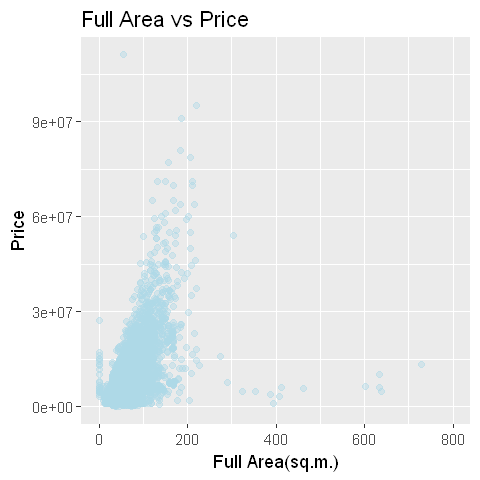

In [9]:
# Price vs Full Area 
options(repr.plot.width=4, repr.plot.height=4)

ggplot(data = train, aes(x = full_sq, y = price_doc)) +
geom_point(color = "light blue", alpha=0.4) +
scale_x_continuous(limits = c(0, 800)) + 
labs(title = "Full Area vs Price", x = "Full Area(sq.m.)", y = "Price")

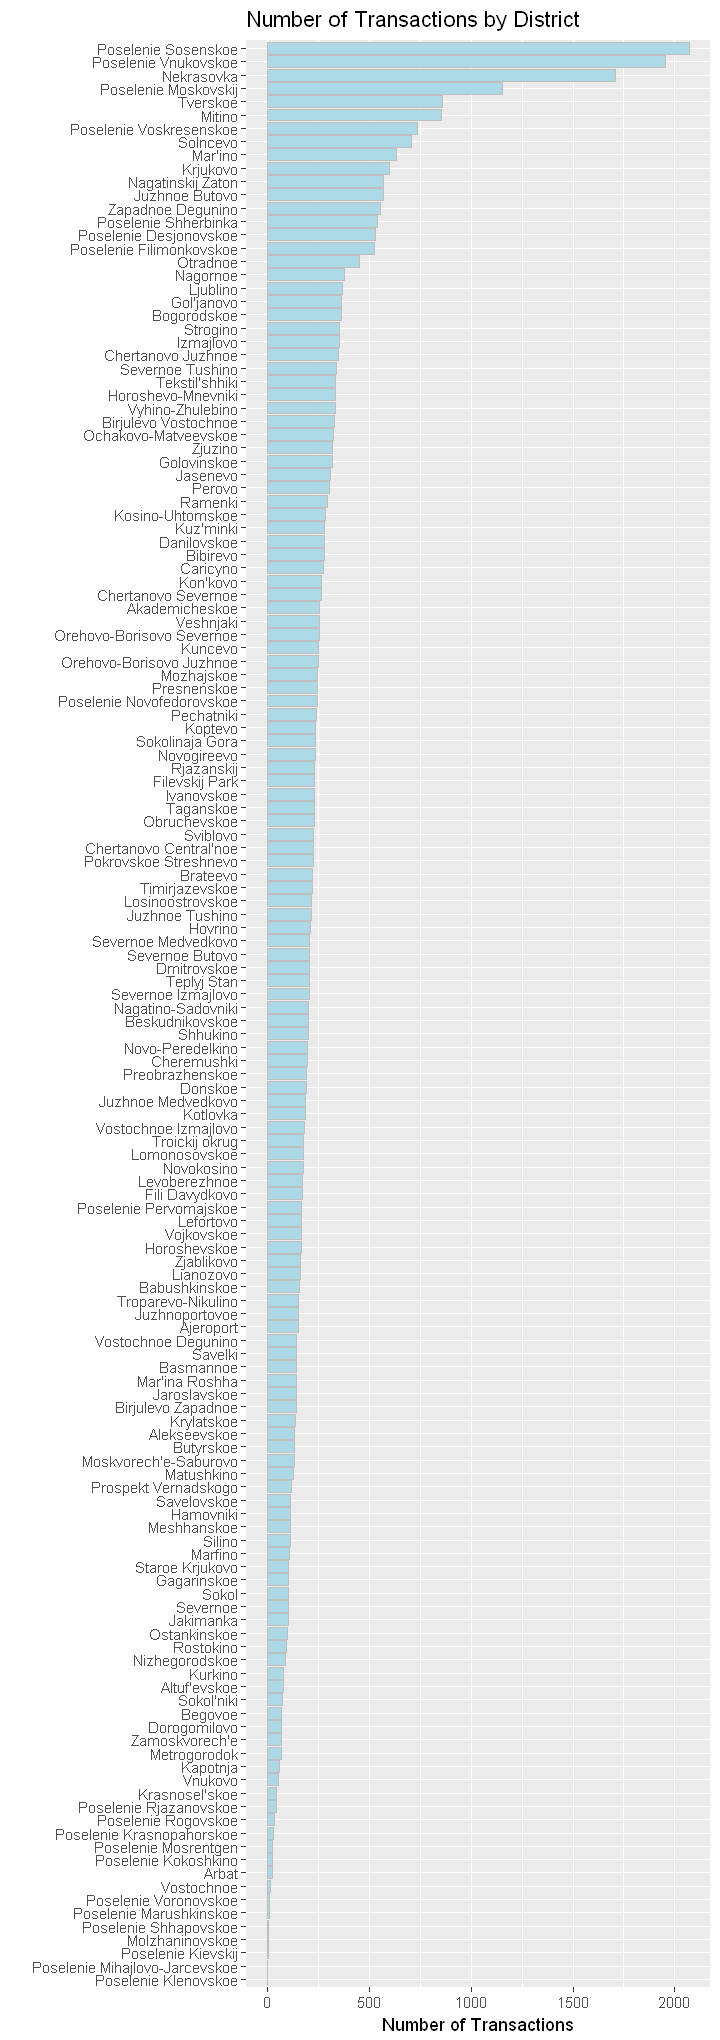

In [10]:
#Let's see number of transaction by sub_area
options(repr.plot.width=6, repr.plot.height=17)
all.data %>% 
    group_by(sub_area) %>%
    summarize(n=n()) %>%
    ggplot(aes(x=reorder(sub_area, n), y=n)) + 
    geom_bar(stat='identity', color = "gray", fill = "light blue") + 
    coord_flip() +
    labs(y='Number of Transactions', x='', title='Number of Transactions by District')

In [11]:
# woork with sub_area, create new variables neighborhood
Zelenograd <- c("Krjukovo","Matushkino","Savelki","Silino","Staroe Krjukovo")
Novomoskovsky <- c("Poselenie Desjonovskoe","Poselenie Filimonkovskoe","Poselenie Kokoshkino","Poselenie Marushkinskoe","Poselenie Moskovskij","Poselenie Mosrentgen","Poselenie Rjazanovskoe","Poselenie Shherbinka","Poselenie Sosenskoe","Poselenie Vnukovskoe","Poselenie Voskresenskoe")
Troitsky <- c("Poselenie Kievskij","Poselenie Klenovskoe","Poselenie Krasnopahorskoe","Poselenie Mihajlovo-Jarcevskoe","Poselenie Novofedorovskoe","Poselenie Pervomajskoe","Poselenie Rogovskoe","Poselenie Shhapovskoe","Poselenie Voronovskoe","Troickij okrug")
Northern <- c("Ajeroport","Begovoe","Beskudnikovskoe","Dmitrovskoe","Golovinskoe","Horoshevskoe","Hovrino","Koptevo","Levoberezhnoe","Molzhaninovskoe","Savelovskoe","Sokol","Timirjazevskoe","Vojkovskoe","Vostochnoe Degunino","Zapadnoe Degunino")
Southwest <- c("Akademicheskoe","Cheremushki","Gagarinskoe","Jasenevo","Juzhnoe Butovo","Kon'kovo","Kotlovka","Lomonosovskoe","Obruchevskoe","Severnoe Butovo","Teplyj Stan","Zjuzino")
Northeast <- c("Alekseevskoe","Altuf'evskoe","Babushkinskoe","Bibirevo","Butyrskoe","Jaroslavskoe","Juzhnoe Medvedkovo","Lianozovo","Losinoostrovskoe","Mar'ina Roshha","Marfino","Ostankinskoe","Otradnoe","Rostokino","Severnoe","Severnoe Medvedkovo","Sviblovo")
Central <- c("Arbat","Basmannoe","Hamovniki","Jakimanka","Krasnosel'skoe","Meshhanskoe","Presnenskoe","Taganskoe","Tverskoe","Zamoskvorech'e")
Southern <- c("Birjulevo Vostochnoe","Birjulevo Zapadnoe","Brateevo","Caricyno","Chertanovo Central'noe","Chertanovo Juzhnoe","Chertanovo Severnoe","Danilovskoe","Donskoe","Moskvorech'e-Saburovo","Nagatino-Sadovniki","Nagatinskij Zaton","Nagornoe","Orehovo-Borisovo Juzhnoe","Orehovo-Borisovo Severnoe","Zjablikovo")
Eastern <- c("Bogorodskoe","Gol'janovo","Ivanovskoe","Izmajlovo","Kosino-Uhtomskoe","Metrogorodok","Novogireevo","Novokosino","Perovo","Preobrazhenskoe","Severnoe Izmajlovo","Sokol'niki","Sokolinaja Gora","Veshnjaki","Vostochnoe","Vostochnoe Izmajlovo")
Western <-c ("Dorogomilovo","Filevskij Park","Fili Davydkovo","Krylatskoe","Kuncevo","Mozhajskoe","Novo-Peredelkino","Ochakovo-Matveevskoe","Prospekt Vernadskogo","Ramenki","Solncevo","Troparevo-Nikulino","Vnukovo")
Northwest <- c("Horoshevo-Mnevniki","Juzhnoe Tushino","Kurkino","Mitino","Pokrovskoe Streshnevo","Severnoe Tushino","Shhukino","Strogino")
Southeast <- c("Juzhnoportovoe","Kapotnja","Kuz'minki","Lefortovo","Ljublino","Mar'ino","Nekrasovka","Nizhegorodskoe","Pechatniki","Rjazanskij","Tekstil'shhiki","Vyhino-Zhulebino")

all.data$neighborhood[all.data$sub_area %in% Novomoskovsky] <- "Novomoskovsky"
all.data$neighborhood[all.data$sub_area %in% Troitsky] <- "Troitsky"
all.data$neighborhood[all.data$sub_area %in% Northern] <- "Northern"
all.data$neighborhood[all.data$sub_area %in% Southwest] <- "Southwest"
all.data$neighborhood[all.data$sub_area %in% Northeast] <- "Northeast"
all.data$neighborhood[all.data$sub_area %in% Central] <- "Central"
all.data$neighborhood[all.data$sub_area %in% Southern] <- "Southern"
all.data$neighborhood[all.data$sub_area %in% Eastern] <- "Eastern"
all.data$neighborhood[all.data$sub_area %in% Western] <- "Western"
all.data$neighborhood[all.data$sub_area %in% Northwest] <- "Northwest"
all.data$neighborhood[all.data$sub_area %in% Southeast] <- "Southeast"
all.data$neighborhood[all.data$sub_area %in% Zelenograd] <- "Zelenograd"
all.data$neighborhood<-as.factor(all.data$neighborhood)

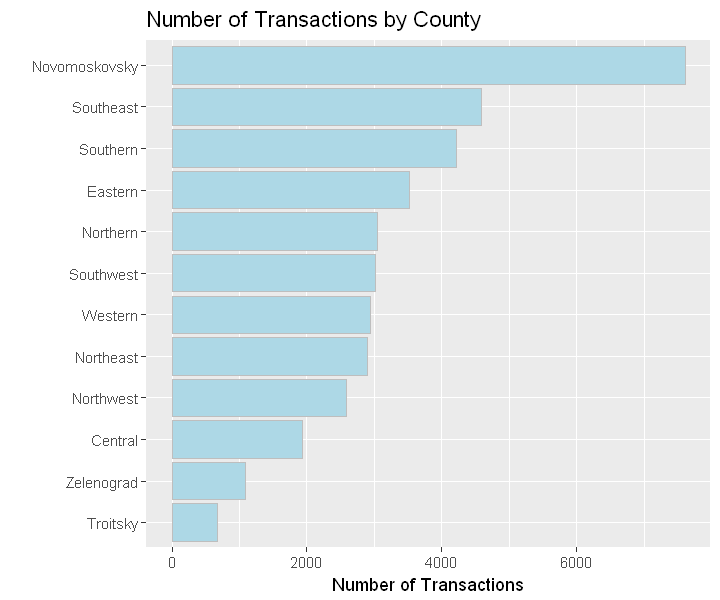

In [12]:
# number pf transaction by neighborhood
options(repr.plot.width=6, repr.plot.height=5)
all.data %>% 
    group_by(neighborhood) %>%
    summarize(n=n()) %>%
    ggplot(aes(x=reorder(neighborhood, n), y=n)) + 
    geom_bar(stat='identity', color = "gray", fill = "light blue") + 
    coord_flip() +
    labs(y='Number of Transactions', x='', title='Number of Transactions by County')

Next, work with datastamp

In [13]:
#work with datastamp
all.data$date <- as.Date(as.character(all.data$timestamp))
all.data$day <- as.integer(format(all.data$date, "%d"))
all.data$month <-as.factor(format(all.data$date, "%m"))
all.data$year <-as.integer(format(all.data$date, "%Y"))

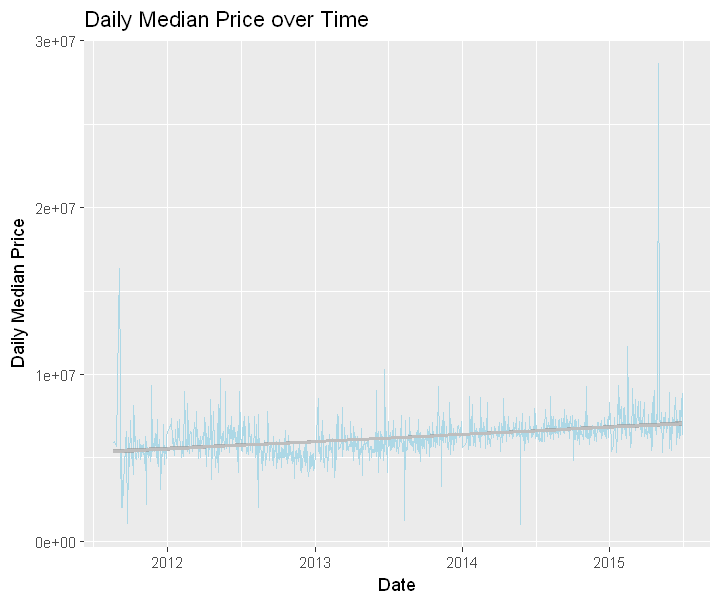

In [14]:
# Median price vs Date 
options(repr.plot.width=6, repr.plot.height=5)
train$date <- as.Date(as.character(train$timestamp))
train %>%
    group_by(date) %>% 
    summarize(med_price = median(price_doc)) %>%
    ggplot(aes(x = date, y = med_price)) +
    geom_line(color = 'light blue') +
    geom_smooth(method = 'lm', color = 'grey', alpha = 0.7) + 
    ggtitle('Daily Median Price over Time') +
    labs(x = "Date", y = "Daily Median Price")

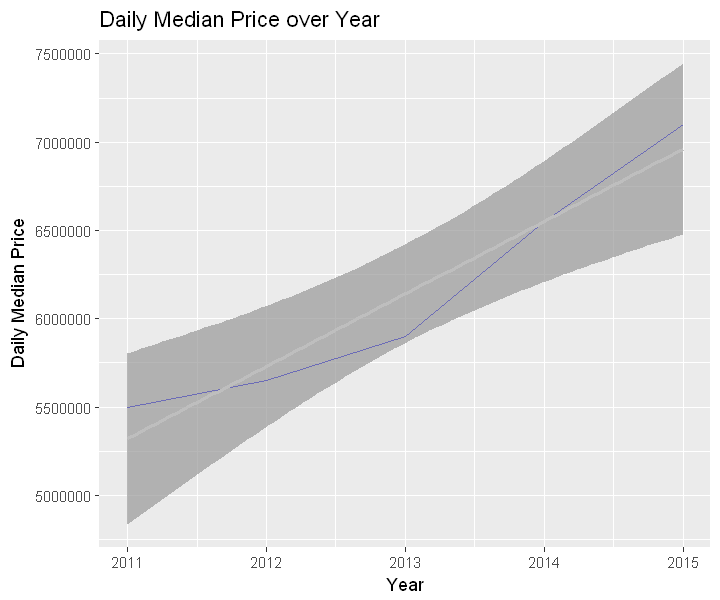

In [15]:
# Median price vs year 
options(repr.plot.width=6, repr.plot.height=5)
train$date <- as.Date(as.character(train$timestamp))
train$year <-as.integer(format(train$date, "%Y"))
train %>%
    group_by(year) %>% 
    summarize(med_price = median(price_doc)) %>%
    ggplot(aes(x = year, y = med_price)) +
    geom_line(color = 'blue') +
    geom_smooth(method = 'lm', color = 'grey', alpha = 0.7) + 
    ggtitle('Daily Median Price over Year') +
    labs(x = "Year", y = "Daily Median Price")

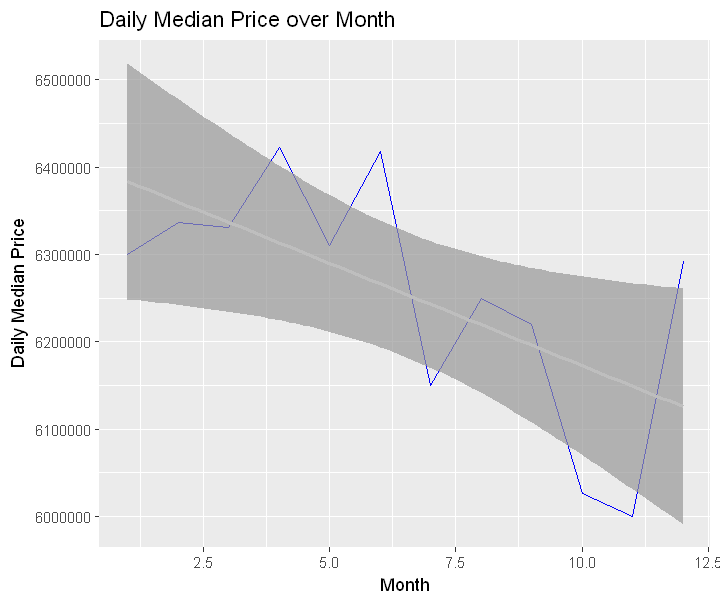

In [16]:
# Median price vs month 
options(repr.plot.width=6, repr.plot.height=5)
train$month <-as.integer(format(train$date, "%m"))
train %>%
    group_by(month) %>% 
    summarize(med_price = median(price_doc)) %>%
    ggplot(aes(x = month, y = med_price)) +
    geom_line(color = 'blue') +
    geom_smooth(method = 'lm', color = 'grey', alpha = 0.7) + 
    ggtitle('Daily Median Price over Month') +
    labs(x = "Month", y = "Daily Median Price")

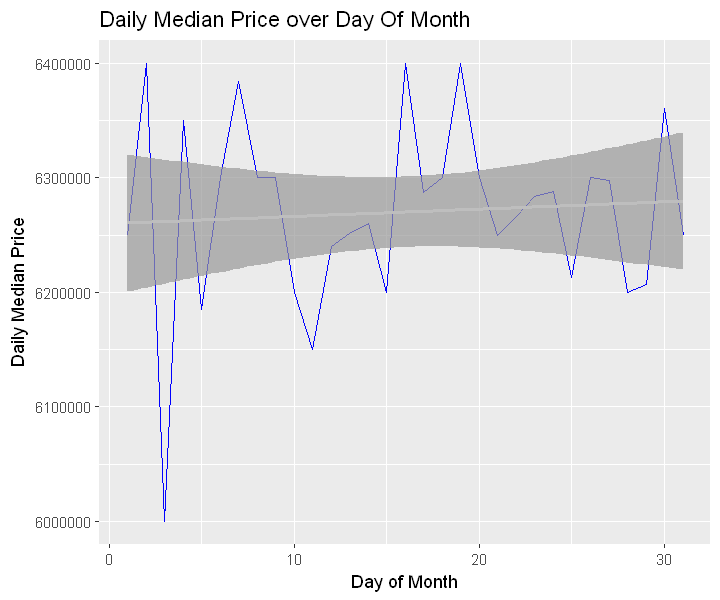

In [17]:
# Median price vs day 
options(repr.plot.width=6, repr.plot.height=5)
train$day <-as.integer(format(train$date, "%d"))
train %>%
    group_by(day) %>% 
    summarize(med_price = median(price_doc)) %>%
    ggplot(aes(x = day, y = med_price)) +
    geom_line(color = 'blue') +
    geom_smooth(method = 'lm', color = 'grey', alpha = 0.7) + 
    ggtitle('Daily Median Price over Day Of Month') +
    labs(x = "Day of Month", y = "Daily Median Price")

I would say that trend is presented only for years, so I'll leave only year part of date. 

Next, I will look for odd values, which I'll replace with NAs before creating a model.  

In [18]:
#Let's see if all max_floor > floor
all.data %>% count(max_floor < floor) 
all.data %>% select(id, max_floor, floor) %>% filter(max_floor < floor)

max_floor < floor,n
FALSE,26425
TRUE,2136
NA,9572


id,max_floor,floor
8219,0,13
8271,1,3
8502,0,2
8534,0,7
8915,0,5
9164,3,8
9260,1,8
9312,1,5
9391,1,10
9415,1,4


In [19]:
#Let's see if all full_sq > life_sq
all.data %>% count(full_sq < life_sq) 
all.data %>% select(id, full_sq, life_sq, kitch_sq, num_room) %>% filter(full_sq < life_sq)

full_sq < life_sq,n
FALSE,30525
TRUE,49
NA,7559


id,full_sq,life_sq,kitch_sq,num_room
1085,44.00,281.00,NA,NA
1189,9.00,44.00,NA,NA
1825,18.00,38.00,NA,NA
1866,30.00,178.00,NA,NA
2012,5.00,40.00,NA,NA
4388,73.00,426.00,NA,NA
6339,37.00,191.00,NA,NA
6534,80.00,88.00,NA,NA
6996,73.00,77.00,NA,NA
7211,31.00,195.00,NA,NA


In [20]:
#Look into the build_year and do some cleaning
table(as.factor(all.data$build_year))


       0        1        2        3       20       71      215     1691 
     899      555        1        2        1        1        2        1 
    1860     1875     1876     1886     1890     1895     1896     1898 
       2        1        1        1        7        2        2        1 
    1900     1902     1904     1905     1906     1907     1908     1910 
       2        1        1        2        2        2        1        6 
    1911     1912     1914     1915     1917     1920     1924     1925 
       4        6        5        5       19        1        4        1 
    1926     1927     1928     1929     1930     1931     1932     1933 
      16       13       18       16        9        9       11        8 
    1934     1935     1936     1937     1938     1939     1940     1941 
      13       12        5       15       12       10       19        4 
    1942     1943     1945     1946     1947     1948     1949     1950 
       1        3        1        2        4      

Here we can see that this field is needed cleaning as well. 

In [21]:
table(as.factor(all.data$state))


   1    2    3    4   33 
7121 8506 7703  549    1 

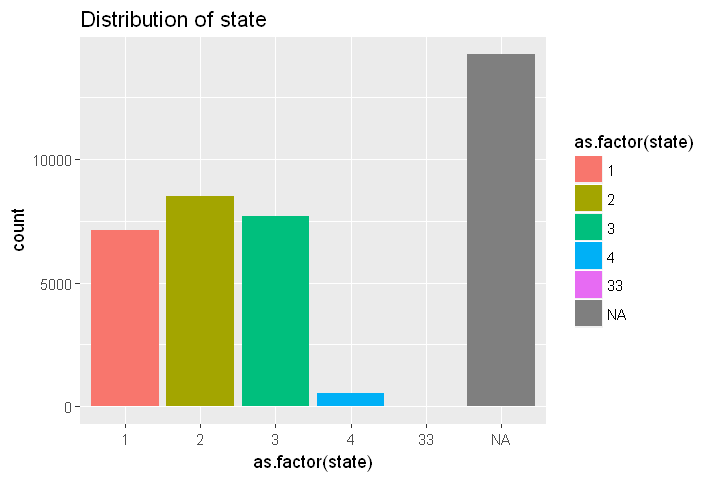

In [22]:
options(repr.plot.width=6, repr.plot.height=4)
all.data %>% 
    ggplot(aes(x=as.factor(state), fill=as.factor(state))) + 
    geom_bar() + 
    ggtitle('Distribution of state')

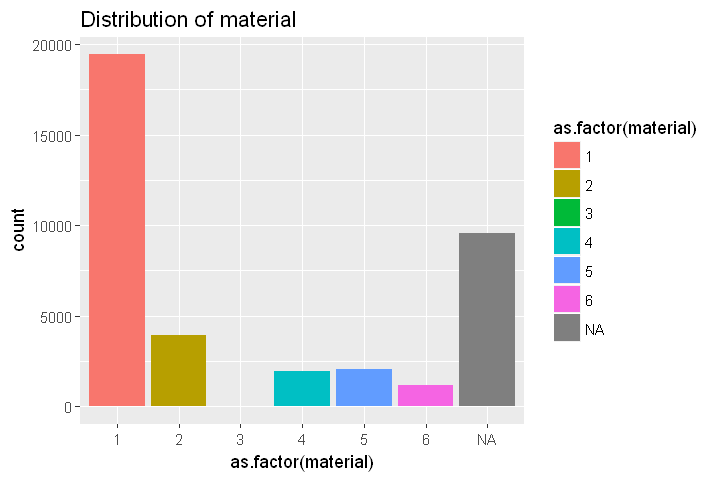

In [23]:
options(repr.plot.width=6, repr.plot.height=4)
all.data %>% 
    ggplot(aes(x=as.factor(material), fill=as.factor(material))) + 
    geom_bar() + 
    ggtitle('Distribution of material')

In [24]:
table(as.factor(all.data$material))


    1     2     3     4     5     6 
19438  3951     2  1963  2048  1159 

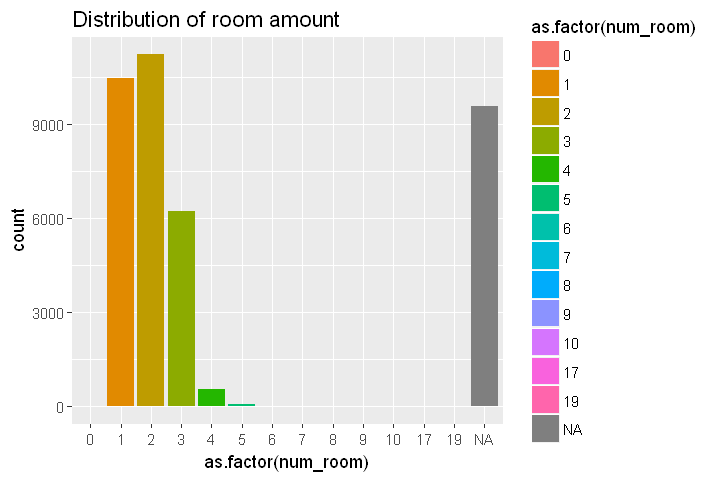

In [25]:
options(repr.plot.width=6, repr.plot.height=4)
all.data %>% 
    ggplot(aes(x=as.factor(num_room), fill=as.factor(num_room))) + 
    geom_bar() + 
    ggtitle('Distribution of room amount')

In [26]:
table(as.factor(all.data$num_room))


    0     1     2     3     4     5     6     7     8     9    10    17    19 
   14 10457 11229  6229   551    59    10     3     3     1     2     1     2 

From this data analysis I can see that we have many missing values and some important fields are messed up, for example full area less then life area of a property or a maximal floor of a building  less than a property floor. So in order to predict prices we have to deal with missing and dirty data. 